# Relative Age Effect in the Uruguayan Soccer Leagues 
## Women's soccer and youth leagues.
This analysis is motivated by the well-known fact that there is an overrepresentation of soccer players born in the first months of the year (January-March) compared with players born in the rest of the months using the total population as a benchmark.
The contributions of this notebook are three:
* confirm the existence of this pattern in Uruguay.
* is to document whether this difference is observed in the Female leagues.
Soccer is very popular in Uruguay, and Uruguayan male players are good. Uruguay's national team is ranked 14th among all national teams, and some of its best players are part of the best teams in the world (Valverde in Real Madrid, Araujo in Barcelona, Nuñez in Liverpool...). However, the Uruguayan Female National team is ranked 66th in the world. Women usually do not play soccer when they are young in Uruguay. Thus, I expect that this pattern is not present among Female players.
* is to document how the birth month contributes to the selection of good players through the years. 
The question is whether the month of birth affects the selection process before players start playing in Youth leagues (at age 13) or whether the month of birth affects selection even when they are in these teams.
Uruguayan professional teams have youth divisions that are very competitive and prepare players to be professional in the future. However, there is considerable attrition in this process. I want to see how the birth month could still affect when the players are teenagers.

### Summary of the results
* Month of birth matters for later success when little information about the team exists.
* Once team-fixed effects are incorporated, the birth month does not seem to matter. Thus, getting into a good team is a better predictor of later success.
* Month of birth discrimination exists for youth players, but this is not so relevant in women and the worst male teams (in terms of the division they play in and their coefficients on the probability of survival). 

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
import seaborn as sn

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### How do births distribute in Uruguay?
First, I use data from the Uruguayan Health Authority to look at the distribution of all births in Uruguay.

In [2]:
births_uy=pd.read_csv('data/nac_uy.csv') ## Opening dataset of births in Uruguay.

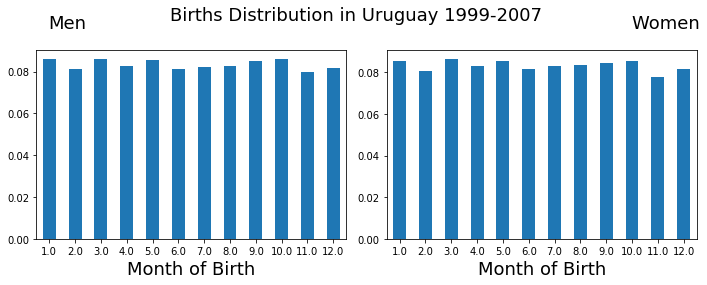

In [3]:
#Frequency of births for Males across months between the years 1999 and 2007.

series1=births_uy[(births_uy['year']!='1998') & (births_uy['year']!='2008') & (births_uy['sexo']==1)].groupby(['month']).count()['Unnamed: 0']
series_to_plot1=series1/series1.sum()
series2=births_uy[(births_uy['year']!='1998') & (births_uy['year']!='2008') & (births_uy['sexo']==2)].groupby(['month']).count()['Unnamed: 0']
series_to_plot2=series2/series2.sum()

fig, axes = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
axe=axes.ravel()

series_to_plot1.plot.bar(rot=0,ax=axe[0])
series_to_plot2.plot.bar(rot=0,ax=axe[1])

fontsize = 18

fig.suptitle('Births Distribution in Uruguay 1999-2007', fontsize=fontsize) # or plt.suptitle('Main title')
axe[0].set_title('Men', fontsize=fontsize)
axe[1].set_title('Women', fontsize=fontsize)
axe[0].title.set_position([0.1,1.085])
axe[1].title.set_position([0.9,1.085])
axe[0].set_xlabel('Month of Birth', fontsize=fontsize)
axe[1].set_xlabel('Month of Birth', fontsize=fontsize)

plt.tight_layout() 

We can see a distribution that is close to a uniform distribution for both men and women.

#### How do births distribute for Uruguayan Professional Male Players?
I use data from transfermarkt.es to look at the distribution of births of professional male players born between 1998 and 2004 in Uruguay.

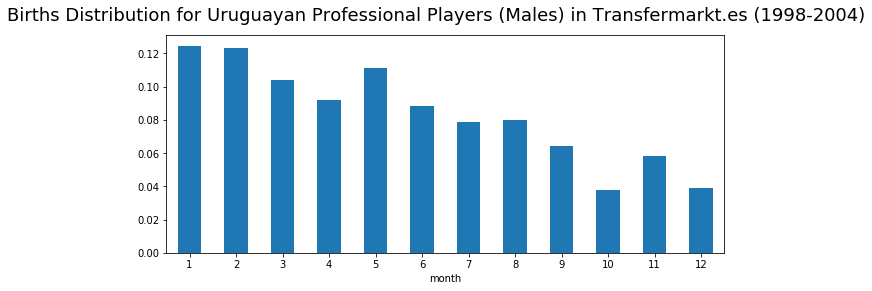

In [4]:
#Frequency of births for Male Professional Players across months between the years 1998 and 2004 (source: transfermarkt.es).

fig, axe = plt.subplots(1,1, figsize=(10,4))  # 1 row, 2 columns

series_tm=pd.read_csv('data/final_tm_uy.csv').groupby('month').count()['names']/len(pd.read_csv('data/final_tm_uy.csv'))
series_tm.plot.bar(rot=0)

fig.suptitle('Births Distribution for Uruguayan Professional Players (Males) in Transfermarkt.es (1998-2004)', fontsize=fontsize) # or plt.suptitle('Main title')
axe.title.set_position([0.5,1.0])


The distribution of births across months for professional players is not uniform, and there is an overrepresentation of those born between January and May.

### Is this related to youth teams?
I want to explore two questions:
a) Does this happen for female players?
b) When this selection is happening? Is it happening before youth teams (age 13 to age 19)? Or is it related to the selection these youth teams make?

I used data-scraping methods to get information from the Football Uruguayan Association about players that played in Uruguay's adult and youth leagues (over age 13) between 2013 and 2022 for both men and women.

In [5]:
df=pd.read_csv('data/final_auf.csv')

In [6]:
import extra_cleaning #code wrote by me to clean that dataset

In [7]:
## I import a program to clean this specific dataset. 
## The first function reads the columns properly and new columns.
## The second function creates a new summary dataser: merged, that computes frequencies for 
# the month of birth for players in male and female professional soccer and youth leagues for the period 2013-2022 in Uruguay.
df=extra_cleaning.cleaning_first(df)
df=extra_cleaning.cleaning_second(df)
merged=extra_cleaning.gen_freqs(df)

In [8]:
## Relevant columns in merge are link: that describes the category (youth league or professional), 
# mob (month of birth) and freq (frequencies).
print(merged.columns.tolist(), merged['link'].unique().tolist())

['mob', 'link', 'fem', 'name_x', 'name_y', 'freq'] ['1A', '3A', 'Mayores', 'Sub 14', 'Sub 15', 'Sub 16', 'Sub 17', 'Sub 19', 'U14 Woman', 'U16', 'U19']


# Uruguayan soccer has a different youth league classification for males and females. 
#### Males
Males are classified according their age in youth league: Under 14 ('Sub 14'), Under 15 ('Sub 15'), Under 16 ('Sub 16'), Under 17 ('Sub 17') and Under 19 ('Sub 19'). Then, there are two other categories: '3A' that corresponds to youth players that could be called to play in the main professional team, and '1A' which corresponds to the professional team.
#### Females
Females are classified according their age in youth league: Under 14 ('U 14 Woman'), Under 16 ('U 16') and Under 19 ('U 19'). Then, there is 'Mayores' which corresponds to the adults team. Not all teams are professional.

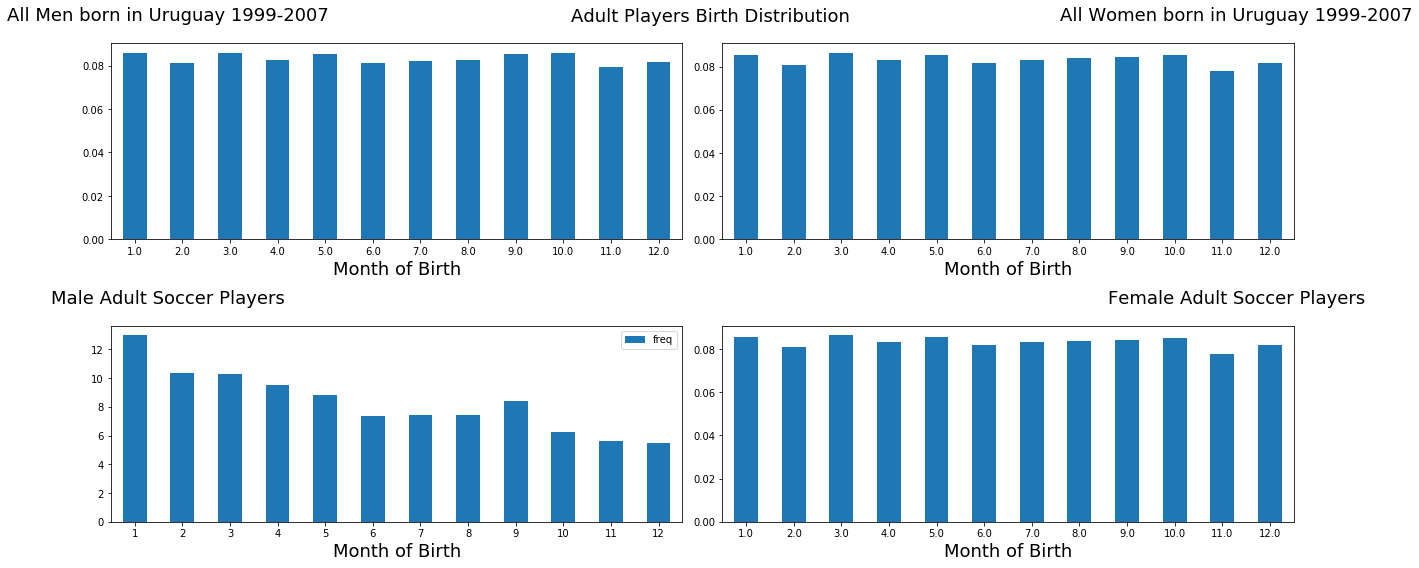

In [9]:
#Frequency of births for Males across months between the years 1999 and 2007.

series1=births_uy[(births_uy['year']!='1998') & (births_uy['year']!='2008') & (births_uy['sexo']==1)].groupby(['month']).count()['Unnamed: 0']
series_to_plot1=series1/series1.sum()
series2=births_uy[(births_uy['year']!='1998') & (births_uy['year']!='2008') & (births_uy['sexo']==2)].groupby(['month']).count()['Unnamed: 0']
series_to_plot2=series2/series2.sum()

fig, axes = plt.subplots(2,2, figsize=(20,8))  # 1 row, 2 columns
axe=axes.ravel()

series_to_plot1.plot.bar(rot=0,ax=axe[0])
series_to_plot2.plot.bar(rot=0,ax=axe[1])

fontsize = 18

fig.suptitle('Births Distribution', fontsize=fontsize) # or plt.suptitle('Main title')
axe[0].set_title('All Men born in Uruguay 1999-2007', fontsize=fontsize)
axe[1].set_title('All Women born in Uruguay 1999-2007', fontsize=fontsize)
axe[0].title.set_position([0.1,1.085])
axe[1].title.set_position([0.9,1.085])
axe[0].set_xlabel('Month of Birth', fontsize=fontsize)
axe[1].set_xlabel('Month of Birth', fontsize=fontsize)

### Players in that play in Uruguay.
merged[merged['link']=='Mayores'][['mob','freq']].set_index('mob')
merged['mob']=merged['mob'].astype(int)
merged=merged.sort_values('mob')
series_to_plot1=merged[merged['link']=='1A'][['mob','freq']].set_index('mob')
series_to_plot3=merged[merged['link']=='Mayores'][['mob','freq']].set_index('mob')


series_to_plot1.plot.bar(rot=0,ax=axe[2])
series_to_plot2.plot.bar(rot=0,ax=axe[3])


fontsize = 18
fig.suptitle('Adult Players Birth Distribution', fontsize=fontsize) # or plt.suptitle('Main title')
axe[2].set_title('Male Adult Soccer Players', fontsize=fontsize)
axe[3].set_title('Female Adult Soccer Players', fontsize=fontsize)
axe[2].set_xlabel('Month of Birth', fontsize=fontsize)
axe[3].set_xlabel('Month of Birth', fontsize=fontsize)

axe[2].title.set_position([0.1,1.085])
axe[3].title.set_position([0.9,1.085])


plt.tight_layout() 
#sexo==1: Male; sexo==2; Female




We can see in this graph how adult players that played in Uruguay between 2013 and 2022 show a different distribution about the birth month depending on their gender. In the case of male players, we can see the same pattern shown in the previous graphs: those born in the first months of the year are overrepresented if we compare it to the uniform distribution for all males. However, the allocation for female adult players is very similar to the one shown by all births.

Next, I compare male and female players for each category: Under 14, Under 16, Under 19, and Adults. I want to see if we observe this same pattern for younger players: are younger female players showing the same distribution as the whole population?

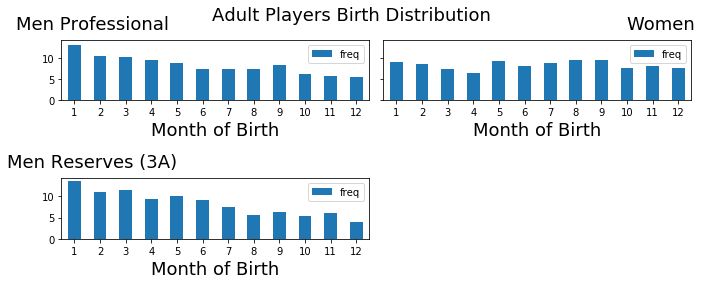

In [10]:
merged[merged['link']=='Mayores'][['mob','freq']].set_index('mob')
merged['mob']=merged['mob'].astype(int)
merged=merged.sort_values('mob')
series_to_plot1=merged[merged['link']=='1A'][['mob','freq']].set_index('mob')
series_to_plot2=merged[merged['link']=='3A'][['mob','freq']].set_index('mob')
series_to_plot3=merged[merged['link']=='Mayores'][['mob','freq']].set_index('mob')

series_to_plot4=merged[merged['link']=='U19'][['mob','freq']].set_index('mob')
series_to_plot5=merged[merged['link']=='Sub 19'][['mob','freq']].set_index('mob')



series_to_plot6=merged[merged['link']=='Sub 16'][['mob','freq']].set_index('mob')
series_to_plot7=merged[merged['link']=='Sub 15'][['mob','freq']].set_index('mob')
series_to_plot8=merged[merged['link']=='U16'][['mob','freq']].set_index('mob')

series_to_plot9=merged[merged['link']=='U14 Woman'][['mob','freq']].set_index('mob')
series_to_plot10=merged[merged['link']=='Sub 14'][['mob','freq']].set_index('mob')


fig, axes = plt.subplots( nrows=2, ncols=2, sharey=True, figsize=(10,4) )
axe=axes.ravel()

series_to_plot1.plot.bar(rot=0,ax=axe[0])
series_to_plot2.plot.bar(rot=0,ax=axe[2])
series_to_plot3.plot.bar(rot=0,ax=axe[1])


fontsize = 18
fig.suptitle('Adult Players Birth Distribution', fontsize=fontsize) # or plt.suptitle('Main title')
axe[0].set_title('Men Professional', fontsize=fontsize)
axe[1].set_title('Women', fontsize=fontsize)
axe[2].set_title('Men Reserves (3A)', fontsize=fontsize)
axe[0].set_xlabel('Month of Birth', fontsize=fontsize)
axe[1].set_xlabel('Month of Birth', fontsize=fontsize)
axe[2].set_xlabel('Month of Birth', fontsize=fontsize)

axe[0].title.set_position([0.1,1.085])
axe[1].title.set_position([0.9,1.085])
axe[2].title.set_position([0.1,1.085])

fig.delaxes(axes[1][1])

plt.tight_layout() 
#sexo==1: Male; sexo==2; Female




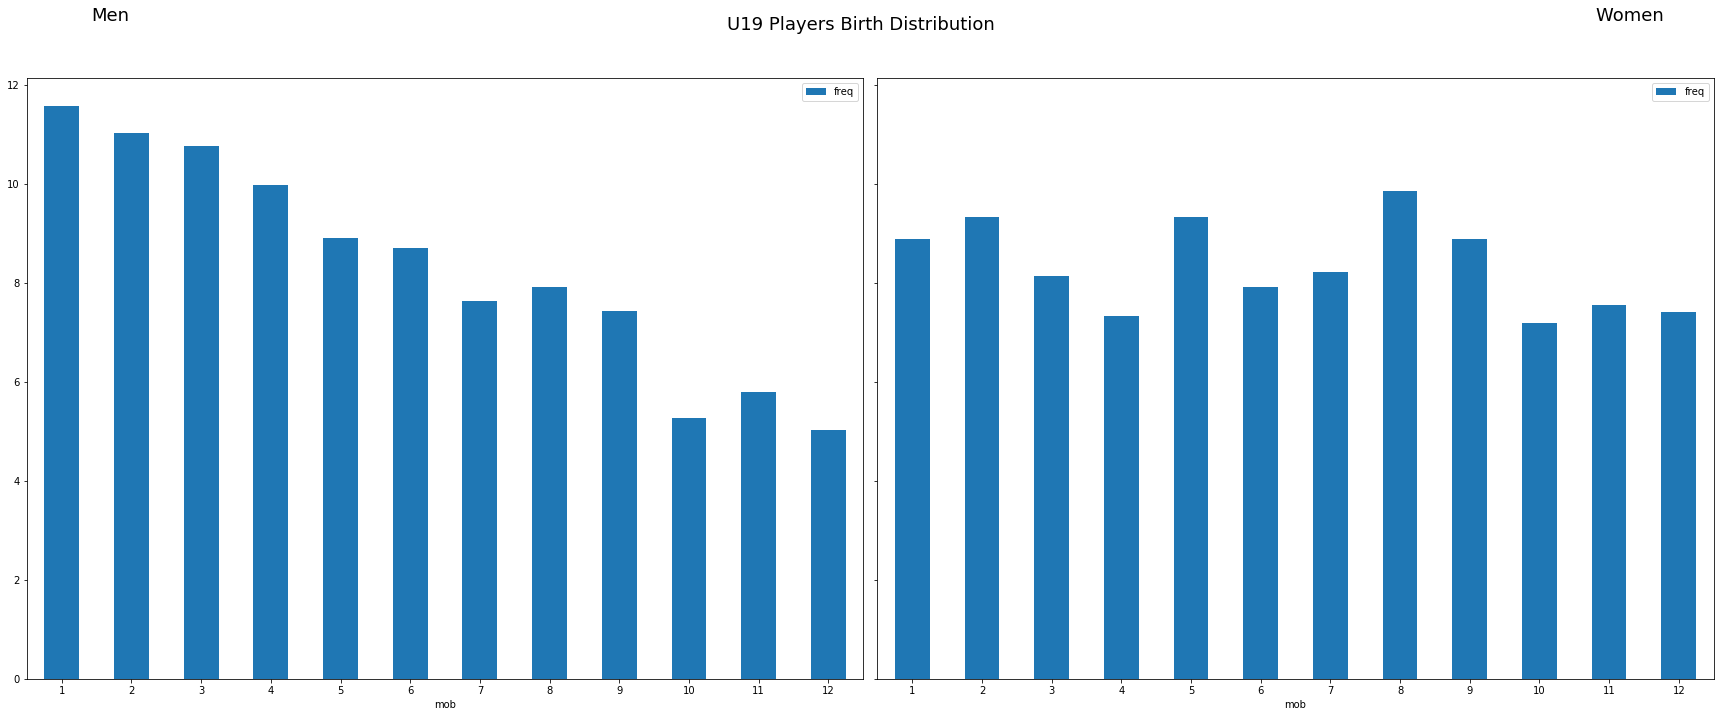

In [11]:
fig, axes = plt.subplots( nrows=1, ncols=2, sharey=True, figsize=(24, 10) )
axe=axes.ravel()

series_to_plot4.plot.bar(rot=0,ax=axe[1])
series_to_plot5.plot.bar(rot=0,ax=axe[0])

fig.suptitle('U19 Players Birth Distribution', fontsize=fontsize) # or plt.suptitle('Main title')
axe[0].set_title('Men', fontsize=fontsize)
axe[1].set_title('Women', fontsize=fontsize)

axe[0].title.set_position([0.1,1.085])
axe[1].title.set_position([0.9,1.085])


plt.tight_layout() 

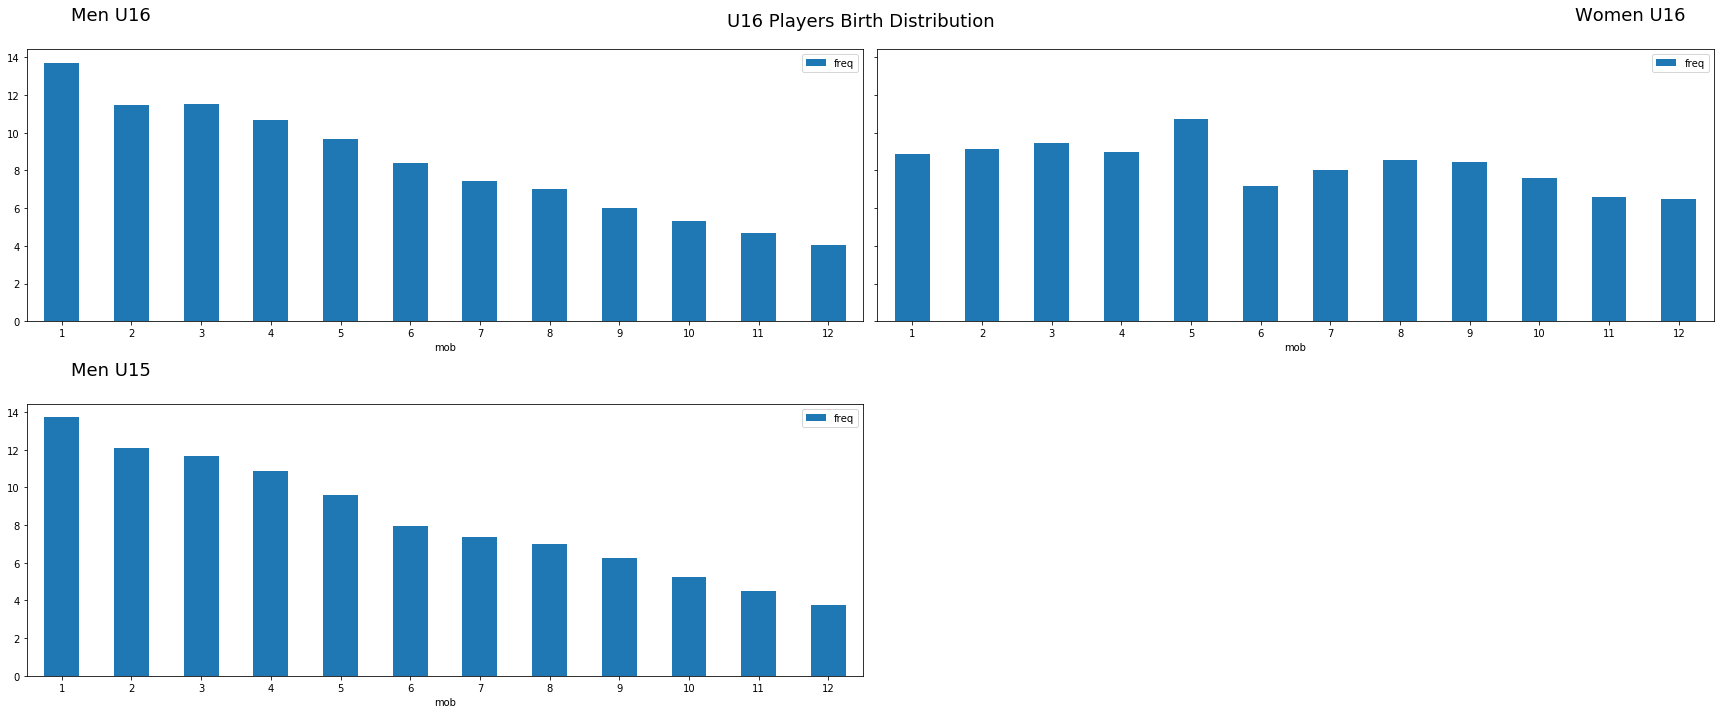

In [12]:
fig, axes = plt.subplots( nrows=2, ncols=2, sharey=True, figsize=(24, 10) )
axe=axes.ravel()


series_to_plot6.plot.bar(rot=0,ax=axe[0])
series_to_plot7.plot.bar(rot=0,ax=axe[2])
series_to_plot8.plot.bar(rot=0,ax=axe[1])

fig.suptitle('U16 Players Birth Distribution', fontsize=fontsize) # or plt.suptitle('Main title')
axe[0].set_title('Men U16', fontsize=fontsize)
axe[1].set_title('Women U16', fontsize=fontsize)
axe[2].set_title('Men U15', fontsize=fontsize)

axe[0].title.set_position([0.1,1.085])
axe[1].title.set_position([0.9,1.085])
axe[2].title.set_position([0.1,1.085])


fig.delaxes(axes[1][1])

plt.tight_layout() 

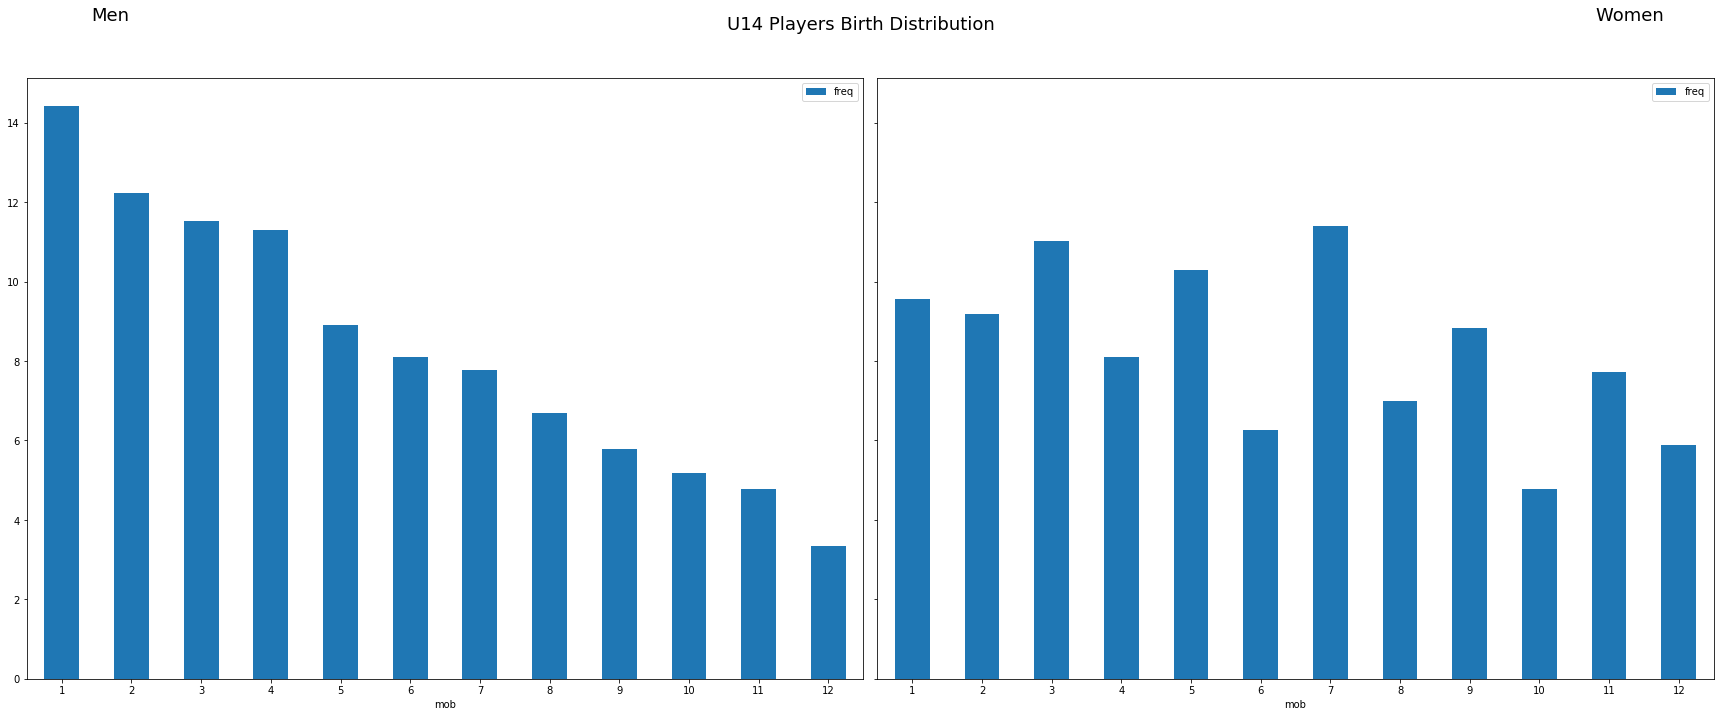

In [13]:
fig, axes = plt.subplots( nrows=1, ncols=2, sharey=True, figsize=(24, 10) )
axe=axes.ravel()


series_to_plot9.plot.bar(rot=0,ax=axe[1])
series_to_plot10.plot.bar(rot=0,ax=axe[0])

fig.suptitle('U14 Players Birth Distribution', fontsize=fontsize) # or plt.suptitle('Main title')
axe[0].set_title('Men', fontsize=fontsize)
axe[1].set_title('Women', fontsize=fontsize)

axe[0].title.set_position([0.1,1.085])
axe[1].title.set_position([0.9,1.085])


plt.tight_layout() 

#### Comment: 
We can see how the pattern already exists in the lowest category in male players: Under 14. Then, the pattern repeats in each category above it. However, for women, a smoother version of that pattern is seen in the Under 16 and Under 14 categories. This change could relate to the increasing popularity of playing soccer for younger women, which could induce more competition to get a spot in these teams. More competition means that soccer teams now choose those players with better characteristics, some of which correlate with the month of birth.

I will only look at male players as the pattern is more relevant for men. I will examine whether the month of birth affects a player's future after he has already been scouted to be part of these youth teams.

### Estimating the effect of the month

In [14]:
df33=extra_cleaning.cleaning_third(df)
df33=df33[df33['fem']==0] ## keeping only males

In [15]:
# For some of the estimations, I will perform them in a train set, so I can compare accuracy across models.
train, test = train_test_split(df33['new_id'].drop_duplicates(), train_size=0.75, random_state=43) 

In [16]:
train_index=train.values.tolist()
test_index=test.values.tolist()

In [17]:
Y_train=df33[df33['new_id'].isin(train_index)]['present']
Y_test=df33[df33['new_id'].isin(test_index)]['present']

In [18]:
df33['t']=df33['seasonord']-df33['minseason']
df33['cons_']=1
X=pd.concat([df33['cons_'],pd.get_dummies(df33['mob'], drop_first=True),df33['first'],df33['t'],df33['seasonord'], df33['new_id']], axis=1)
X_train=X[X['new_id'].isin(train_index)].drop(columns=['new_id'])
X_test=X[X['new_id'].isin(test_index)].drop(columns=['new_id'])

The question I am trying to address is whether the inactivity of player (defined a someone who at any time was registered as a player in the Uruguayan Football Association) is explained by the month of birth. 

First, I will estimate a logit model, where the dependent variable is a binary variable that represents whether the player is still part of any team. This is a balanced panel, thus, anytime a player stops being part of any team, the variable *present*=0. If the player is on a team, the variable *present*=1.

To explain whether the player is still active, I use a set of independent variables that consist of:
* a constant
* a dummy for each birth month (I exclude January to avoid collinearity in this set of variables)
* a dummy for whether the last team the player was in competes in the first division in 2022.
* a dummy for each season
* and a variable that measures how many seasons that person played in the Uruguayan Soccer Leagues.

I use statsmodels to estimate a logit model because it allows me to analyze whether the coefficients are statiscally significant different from 0.

In [19]:
log_clf =sm.Logit(Y_train,X_train)
classifier = log_clf.fit()
print(classifier.summary2())

Optimization terminated successfully.
         Current function value: 0.490079
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.292     
Dependent Variable: present          AIC:              65836.8208
Date:               2022-10-31 01:25 BIC:              65973.5387
No. Observations:   67139            Log-Likelihood:   -32903.   
Df Model:           14               LL-Null:          -46477.   
Df Residuals:       67124            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
             Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
cons_        2.3180    0.0378    61.3539  0.0000   2.2439   2.3920
02          -0.0500    0.0395    -1.2663  0.2054  -0.1273   0.

Using this model, we can see how a player born in February does not show a different probability of dropping out of Uruguayan soccer to a player born in January. However, this is different for a player born in December. That player shows a lower probability of staying in the dataset.
We can also compare two players born in two different months. For example, we can test the difference between the coefficients of a player born in March and November. We can see how there is a difference at the 5% level of significance, which means that players born in November are also more prone to drop out of the panel.

In [20]:
hypotheses = '03 = 11'
t_test = classifier.t_test(hypotheses)
print(t_test)

                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0910      0.051      1.796      0.073      -0.008       0.190


In the output of the estimation, we can see that being in a first division team increases the probability of dropping out. Could it be that the effect of the birth month is different for players in first division teams than for players in second division teams? I add interactions between these set of dummies to answer that question.

In [21]:
df33['fmob']=(df33['mob'].astype(int)+100*df33['first']).astype(str)
## If the player was born in January and plays in First Division, fmob=101. If he plays in second division, fmob=1.
X2=pd.concat([df33['cons_'],pd.get_dummies(df33['fmob'], drop_first=True),df33['t'],df33['seasonord'], df33['new_id']], axis=1)
X_train2=X2[X2['new_id'].isin(train_index)].drop(columns=['new_id'])
X_test2=X2[X2['new_id'].isin(test_index)].drop(columns=['new_id'])


In [22]:
#log_clf = LogisticRegression()
log_clf =sm.Logit(Y_train,X_train2)
classifier = log_clf.fit()

print(classifier.summary2())

Optimization terminated successfully.
         Current function value: 0.489958
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.292     
Dependent Variable: present          AIC:              65842.5342
Date:               2022-10-31 01:25 BIC:              66079.5117
No. Observations:   67139            Log-Likelihood:   -32895.   
Df Model:           25               LL-Null:          -46477.   
Df Residuals:       67113            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
             Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
cons_        2.3172    0.0405    57.2287  0.0000   2.2379   2.3966
10.0        -0.3068    0.0553    -5.5453  0.0000  -0.4152  -0.

The benchmark player is a someone born in January that plays in a team of the second division. For another player in the second division, being born in a later month affects negatively the probability of staying in the dataset. However, this difference is significative when comparing with players born after July.

A player born in January that plays in the first division also has a higher probability of dropping out than the one in the second division. However, a striking result is that players in the first division born in January don't show any difference in probability than both born in December (something that happens for those bortn in December)

In [23]:
hypotheses = '101.0 = 112.0'
t_test = classifier.t_test(hypotheses)
print(t_test)

                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.1015      0.106      0.961      0.336      -0.105       0.309


Given I estimated two models, I proceed to compare which of the both models predicts better the variable present. To do this, I use the same test set. To compare both models I look at the accuracy score (fraction of correct predictions) and the F1 score (the harmonic mean between precision and recall).

Accuracy Percentage (%) :  77.2190424275461 . F1 Percentage (%) :  77.61860132994154


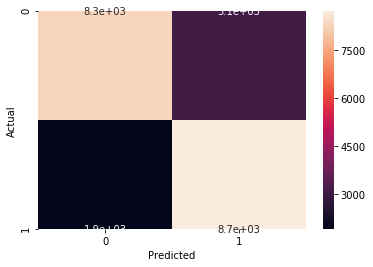

In [24]:
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,Y_train)
y_pred=logistic_regression.predict(X_test)
confusion_matrix = pd.crosstab(Y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
accuracy = accuracy_score(Y_test, y_pred)
accuracy_percentage = 100 * accuracy
print("Accuracy Percentage (%) : ", accuracy_percentage, ". F1 Percentage (%) : ",f1_score(Y_test, y_pred)*100)

Accuracy Percentage (%) :  77.23267011901517 . F1 Percentage (%) :  77.58697790895268


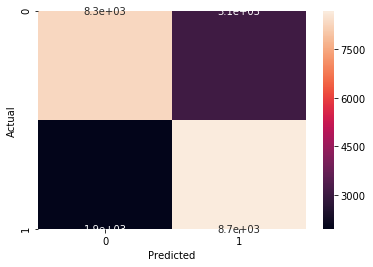

In [25]:
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train2,Y_train)
y_pred=logistic_regression.predict(X_test2)
confusion_matrix = pd.crosstab(Y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
accuracy = accuracy_score(Y_test, y_pred)
accuracy_percentage = 100 * accuracy
print("Accuracy Percentage (%) : ", accuracy_percentage, ". F1 Percentage (%) : ", f1_score(Y_test, y_pred)*100)

In both cases, the model without the interactions perform slightly better.

### Looking at expectations and probabilities
I can also look at the probability of still playing according to each month using survival models. First, I will compute the average frequency of still playing after x seasons for male players that were in the Under 14 category in the season 2013/2014. I can also discriminate this probability by the month of birth of the players 

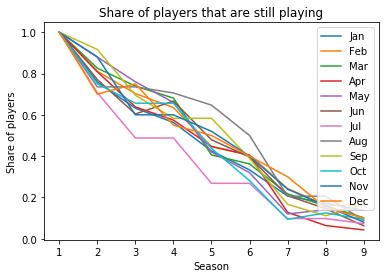

In [26]:
temp=df33[df33['fem']==0]
first_cat=df33[(df33['catord']==1)]['new_id'].unique().tolist() ### get the ids of players present at the first season

temp=temp[(temp['minseason']==1) &  temp['new_id'].isin(first_cat)] ### keep those players present at the first season
temp4=pd.DataFrame()
for j in range(1,10):
    temp2=temp[temp['seasonord']==j]
    temp3=temp2[['new_id', 'mob', 'present', 'catord']].drop_duplicates().groupby(['mob'])['present'].mean()
    temp4=pd.concat([temp4,temp3], axis=1)

x=list(range(1,10))

l1=temp4.loc['01'].tolist()
l2=temp4.loc['02'].tolist()
l3=temp4.loc['03'].tolist()
l4=temp4.loc['04'].tolist()
l5=temp4.loc['05'].tolist()
l6=temp4.loc['06'].tolist()
l7=temp4.loc['07'].tolist()
l8=temp4.loc['08'].tolist()
l9=temp4.loc['09'].tolist()
l10=temp4.loc['10'].tolist()
l11=temp4.loc['11'].tolist()
l12=temp4.loc['12'].tolist()

plt.plot(x,l1,label='Jan')
plt.plot(x,l2,label='Feb')
plt.plot(x,l3,label='Mar')
plt.plot(x,l4,label='Apr')
plt.plot(x,l5,label='May')
plt.plot(x,l6,label='Jun')
plt.plot(x,l7,label='Jul')
plt.plot(x,l8,label='Aug')
plt.plot(x,l9,label='Sep')
plt.plot(x,l10,label='Oct')
plt.plot(x,l11,label='Nov')
plt.plot(x,l12,label='Dec')

plt.title('Share of players that are still playing')
plt.xlabel('Season')
plt.ylabel('Share of players')
plt.legend()
plt.show()

##### Comment
We can see the probability of still playing nine years later, starting in a youth league, is lower than 20 percent. This probability decreases every year.
We can also see no noticeable pattern related to the birth month. 
Given that the logit model indicated that the birth month mattered in the second division teams, I only keep those players and compute average probabilities only with them.

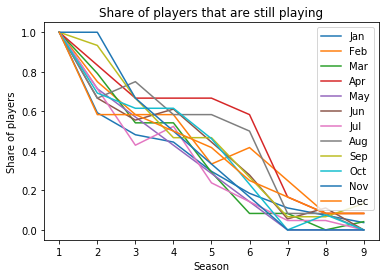

In [27]:
temp=df33[df33['fem']==0]
sec_div=df33[(df33['first']==0) & (df33['catord']==1)]['new_id'].unique().tolist()

temp=temp[temp['minseason']==1 &  temp['new_id'].isin(sec_div)]
temp4=pd.DataFrame()
for j in range(1,10):
    temp2=temp[temp['seasonord']==j]
    temp3=temp2[['new_id', 'mob', 'present', 'catord']].drop_duplicates().groupby(['mob'])['present'].mean()
    temp4=pd.concat([temp4,temp3], axis=1)

x=list(range(1,10))

l1=temp4.loc['01'].tolist()
l2=temp4.loc['02'].tolist()
l3=temp4.loc['03'].tolist()
l4=temp4.loc['04'].tolist()
l5=temp4.loc['05'].tolist()
l6=temp4.loc['06'].tolist()
l7=temp4.loc['07'].tolist()
l8=temp4.loc['08'].tolist()
l9=temp4.loc['09'].tolist()
l10=temp4.loc['10'].tolist()
l11=temp4.loc['11'].tolist()
l12=temp4.loc['12'].tolist()

plt.plot(x,l1,label='Jan')
plt.plot(x,l2,label='Feb')
plt.plot(x,l3,label='Mar')
plt.plot(x,l4,label='Apr')
plt.plot(x,l5,label='May')
plt.plot(x,l6,label='Jun')
plt.plot(x,l7,label='Jul')
plt.plot(x,l8,label='Aug')
plt.plot(x,l9,label='Sep')
plt.plot(x,l10,label='Oct')
plt.plot(x,l11,label='Nov')
plt.plot(x,l12,label='Dec')

plt.title('Share of players that are still playing')
plt.xlabel('Season')
plt.ylabel('Share of players')
plt.legend()
plt.show()

##### Comment.
We can see the probability of still playing nine years later, starting in a youth league, is lower than 10 percent (lower than the total average). This means that players that start in second division teams usually not make it to keep playing soccer. This probability decreases every year (with a .
We can also see no noticeable pattern related to the birth month. 
I proceed to estimate some basic Hazard models.

First, I fit the Kaplan-Meier estimate, which is a non-parametric statistic used to estimate the survival function from lifetime data. I use it to compare the estimates of the survival probabilities for different months of birth (which I split in four month-periods). For this analysis, I only keep those players for which I have a register when they were in the Under 14 category. The mentioned estimator handles the natural censorship that comes from the fact that some players are still playing (and never dropped out).

In [28]:
temp=df33[df33['fem']==0]
first_div=df33[(df33['catord']==1)]['new_id'].unique().tolist()
temp['duration']=temp['maxseason']-temp['minseason']+1
temp['events_observed']=temp.loc[temp['maxseason']<9,  'events_observed']=0

first_div=df33[(df33['first']==0) & (df33['catord']==1)]['new_id'].unique().tolist()

temp=temp[temp['minseason']==1 &  temp['new_id'].isin(first_div)]
temp=df33[df33['fem']==0]
first_div=df33[(df33['catord']==1)]['new_id'].unique().tolist()
temp['duration']=temp['maxseason']-temp['minseason']+1
temp.loc[temp['maxseason']<9,'events_observed']=1
temp.loc[temp['maxseason']==9,'events_observed']=0

Text(0, 0.5, 'Share of players')

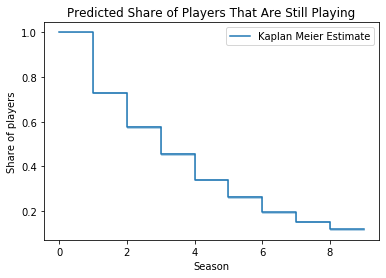

In [29]:
kmf = KaplanMeierFitter()
kmf.fit(temp['duration'], temp['events_observed'],label='Kaplan Meier Estimate')
kmf.plot()
plt.title('Predicted Share of Players That Are Still Playing')
plt.xlabel('Season')
plt.ylabel('Share of players')

We can see that, without splitting players according the month of birth, that the highest drop is on the first season (between ages 13-15. However, after that, the decline still happens.

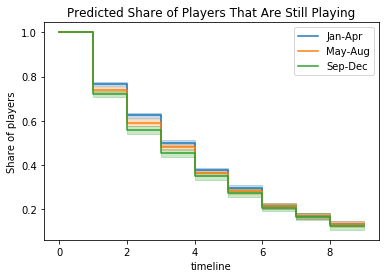

In [30]:
temp=df33[df33['fem']==0]
first_div=df33[(df33['catord']==1)]['new_id'].unique().tolist()
temp['duration']=temp['maxseason']-temp['minseason']+1
temp['events_observed']=temp.loc[temp['maxseason']<9,  'events_observed']=0


first_div=df33[(df33['first']==0) & (df33['catord']==1)]['new_id'].unique().tolist()

temp=temp[temp['minseason']==1 &  temp['new_id'].isin(first_div)]
temp=df33[df33['fem']==0]
first_div=df33[(df33['catord']==1)]['new_id'].unique().tolist()
temp['duration']=temp['maxseason']-temp['minseason']+1
temp.loc[temp['maxseason']<9,'events_observed']=1
temp.loc[temp['maxseason']==9,'events_observed']=0

temp=temp.drop_duplicates('new_id')

T=temp['duration']
E=temp['events_observed']

temp.loc[temp['mob'].astype(int)<=4,'fob']=1
temp.loc[(temp['mob'].astype(int)>=5) & (temp['mob'].astype(int)<=8),'fob']=2
temp.loc[(temp['mob'].astype(int)>=9) & (temp['mob'].astype(int)<=12),'fob']=3

groups = temp['fob']

i1 = (groups == 1) 
i2 = (groups == 2)     ## group i2 , having the pandas series  for the 2nd cohort
i3 = (groups == 3)      ## group i1 , having the pandas series  for the 1st cohort



kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

## fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='Jan-Apr')
a1 = kmf1.plot()
kmf1.fit(T[i2], E[i2], label='May-Aug')
a2 = kmf1.plot()
kmf1.fit(T[i3], E[i3], label='Sep-Dec')

plt.title('Predicted Share of Players That Are Still Playing')
plt.ylabel('Share of players')

kmf1.plot(ax=a1)

When we split into four-month periods, we can see that those born between January and April show a higher predicted share of still playing in the younger categories. However, it seems to be a non-significant difference in later seasons.

As an alternative, I proceed to analyze this with a Cox proportional hazard model. This is a parametric model that assumes the relative risk of dropping out between to subjects is constant over time. The model allows to considerate the effect of covariates. The mentioend ratio depends on the covariates we use. I look at how two subjects that were born at different months differ on their risk.

In [31]:
cph = CoxPHFitter()
temp=df33[df33['fem']==0]
first_div=df33[(df33['catord']==1)]['new_id'].unique().tolist()
temp['duration']=temp['maxseason']-temp['minseason']+1
temp['events_observed']=temp.loc[temp['maxseason']<9,  'events_observed']=0


first_div=df33[(df33['catord']==1)]['new_id'].unique().tolist()

temp=temp[temp['minseason']==1 &  temp['new_id'].isin(first_div)]
temp=df33[df33['fem']==0]
first_div=df33[(df33['catord']==1)]['new_id'].unique().tolist()
temp['duration']=temp['maxseason']-temp['minseason']+1
temp.loc[temp['maxseason']<9,'events_observed']=1
temp.loc[temp['maxseason']==9,'events_observed']=0

temp=temp.drop_duplicates('new_id')


df_dummy=pd.get_dummies(pd.concat([temp['mob'], temp['duration'],temp['events_observed'],temp['first']], axis=1), drop_first=True)
cph.fit(df_dummy, 'duration', 'events_observed')
cph.print_summary()

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 15110 total observations, 5049 right-censored observations>
             duration col = 'duration'
                event col = 'events_observed'
      baseline estimation = breslow
   number of observations = 15110
number of events observed = 10061
   partial log-likelihood = -88962.08
         time fit was run = 2022-10-31 05:25:43 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
first      -0.26       0.77       0.02            -0.30            -0.22                 0.74                 0.80
mob_02     -0.00       1.00       0.04            -0.09             0.08                 0.92                 1.08
mob_03     -0.01       0.99       0.04            -0.09             0.07                 0.92                 1.08
mob_04     -0.01       0.99       0.04            -0.09             0.07                 0.91                 1.07
mob_05      0.02       1.02       0.04            -0.07             0.10                 0.93                 1.10
mob_06      0.03       1.03       0.04            -0.06             0.11                 0.94                 1.12
mob_07      0.03       1.03       0.05            -0.06             0.12                 0.94                 1.13
mob_08      0.06       1.06       0.05            -0.03             0.15                 0.97                 1.16
mob_09      0.04       1.04       0.05            -0.05             0.13                 0.95                 1.14
mob_10      0.11       1.12       0.05             0.01             0.21                 1.01                 1.23
mob_11      0.04       1.04       0.05            -0.07             0.14                 0.94                 1.15
mob_12      0.11       1.12       0.05             0.01             0.22                 1.01                 1.24

            cmp to      z      p   -log2(p)
covariate                                  
first         0.00 -13.03 <0.005     126.42
mob_02        0.00  -0.11   0.91       0.14
mob_03        0.00  -0.19   0.85       0.24
mob_04        0.00  -0.30   0.77       0.39
mob_05        0.00   0.35   0.72       0.46
mob_06        0.00   0.61   0.54       0.89
mob_07        0.00   0.67   0.50       1.00
mob_08        0.00   1.32   0.19       2.43
mob_09        0.00   0.83   0.41       1.30
mob_10        0.00   2.25   0.02       5.34
mob_11        0.00   0.69   0.49       1.03
mob_12        0.00   2.11   0.04       4.83
---
Concordance = 0.55
Partial AIC = 177948.15
log-likelihood ratio test = 189.12 on 12 df
-log2(p) of ll-ratio test = 110.43

Text(0, 0.5, 'Months')

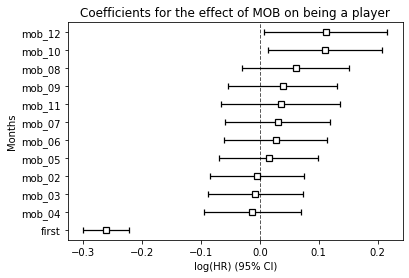

In [32]:
cph.plot()
plt.title('Coefficients for the effect of MOB on being a player')
plt.ylabel('Months')

We can also simulate the trajectories for individuals born in February and December that play for either teams in first division or second division and see how there are differences in these trajectories. By definition, these trajectories are parallel.

Text(0, 0.5, 'Share of players')

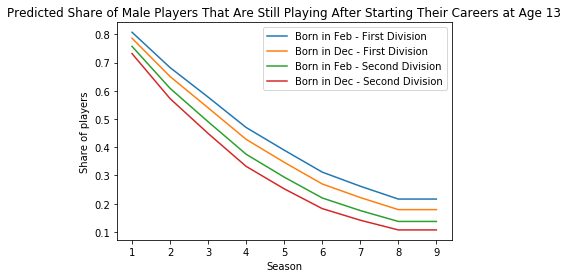

In [33]:
a=df_dummy[(df_dummy['first']==1) & (df_dummy['mob_02']==1)].iloc[0,:].name
b=df_dummy[(df_dummy['first']==1) & (df_dummy['mob_12']==1)].iloc[0,:].name
c=df_dummy[(df_dummy['first']==0) & (df_dummy['mob_02']==1)].iloc[0,:].name
d=df_dummy[(df_dummy['first']==0) & (df_dummy['mob_12']==1)].iloc[0,:].name
ni=['Born in Feb - First Division','Born in Dec - First Division','Born in Feb - Second Division','Born in Dec - Second Division']
sample=df_dummy.loc[[a,b,c,d]].iloc[:,2:]
sample.index=ni
cph.predict_survival_function(sample).plot()
plt.title('Predicted Share of Male Players That Are Still Playing After Starting Their Careers at Age 13')
plt.xlabel('Season')
plt.ylabel('Share of players')

### What about the teams?
We have seen that besides the month of birth, how good is the team affects the survival probability. Thus, instead of adding a dummy variable for being in first division, I include a dummy variable for each team.

In [34]:
cph = CoxPHFitter()
temp=df33[df33['fem']==0]
first_div=df33[(df33['catord']==1)]['new_id'].unique().tolist()
temp['duration']=temp['maxseason']-temp['minseason']+1
temp['events_observed']=temp.loc[temp['maxseason']<9,  'events_observed']=0


first_div=df33[(df33['catord']==1)]['new_id'].unique().tolist()

temp=temp[temp['minseason']==1 &  temp['new_id'].isin(first_div)]
temp=df33[df33['fem']==0]
first_div=df33[(df33['catord']==1)]['new_id'].unique().tolist()
temp['duration']=temp['maxseason']-temp['minseason']+1
temp.loc[temp['maxseason']<9,'events_observed']=1
temp.loc[temp['maxseason']==9,'events_observed']=0

temp=temp.drop_duplicates('new_id')


df_dummy=pd.get_dummies(pd.concat([temp['teams'],temp['duration'],temp['events_observed'], temp['mob'] ], axis=1), drop_first=True)
cph.fit(df_dummy, 'duration', 'events_observed')
cph.print_summary()

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 15110 total observations, 5049 right-censored observations>
             duration col = 'duration'
                event col = 'events_observed'
      baseline estimation = breslow
   number of observations = 15110
number of events observed = 10061
   partial log-likelihood = -88306.77
         time fit was run = 2022-10-31 05:25:44 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
teams_127    0.01       1.01       0.08            -0.15             0.16                 0.87                 1.18
teams_137    0.03       1.03       0.08            -0.13             0.18                 0.88                 1.20
teams_139   -0.76       0.47       0.08            -0.92            -0.60                 0.40                 0.55
teams_150    0.21       1.23       0.09             0.03             0.38                 1.03                 1.47
teams_156   -0.16       0.85       0.08            -0.31            -0.01                 0.73                 0.99
teams_187    0.11       1.12       0.08            -0.04             0.27                 0.96                 1.31
teams_190   -0.99       0.37       0.09            -1.16            -0.82                 0.31                 0.44
teams_20     0.13       1.14       0.08            -0.02             0.28                 0.98                 1.32
teams_202   -0.09       0.92       0.08            -0.24             0.07                 0.78                 1.07
teams_205   -0.59       0.56       0.08            -0.75            -0.43                 0.47                 0.65
teams_226   -0.36       0.70       0.08            -0.52            -0.20                 0.60                 0.82
teams_231   -0.58       0.56       0.08            -0.74            -0.42                 0.48                 0.66
teams_240   -0.06       0.94       0.08            -0.22             0.10                 0.80                 1.10
teams_25    -0.39       0.68       0.08            -0.54            -0.23                 0.58                 0.80
teams_265    0.03       1.03       0.08            -0.12             0.19                 0.89                 1.20
teams_280    0.44       1.55       0.14             0.17             0.70                 1.19                 2.02
teams_284   -0.71       0.49       0.08            -0.88            -0.55                 0.42                 0.58
teams_4462   0.14       1.15       0.08            -0.02             0.29                 0.98                 1.33
teams_4463  -0.61       0.54       0.08            -0.77            -0.45                 0.46                 0.64
teams_4471  -0.21       0.81       0.08            -0.36            -0.05                 0.69                 0.95
teams_59     0.07       1.08       0.08            -0.08             0.23                 0.92                 1.26
teams_65     0.10       1.10       0.08            -0.06             0.26                 0.94                 1.30
teams_79     0.83       2.29       0.08             0.67             0.99                 1.96                 2.68
teams_81    -0.83       0.44       0.08            -0.99            -0.66                 0.37                 0.52
teams_89     0.15       1.16       0.08            -0.00             0.31                 1.00                 1.36
teams_91     0.06       1.07       0.08            -0.08             0.21                 0.92                 1.24
teams_92     0.31       1.36       0.08             0.16             0.46                 1.17                 1.58
mob_02      -0.03       0.97       0.04            -0.12             0.05                 0.89                 1.05
mob_03      -0.03       0.97       0.04            -0.11             0.05                 0.89                 1.05
mob_04      -0.06       

We can see that the month of birth coefficients are more compressed and are usually closer than 0 than any teams' coefficient. 

Text(0, 0.5, 'Variables')

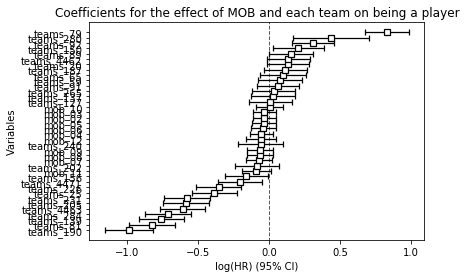

In [35]:
cph.plot()
plt.title('Coefficients for the effect of MOB and each team on being a player')
plt.ylabel('Variables')

In fact, we can compare the curves for team with the lowest coefficient (190; Defensor Sp., which means that exp(coef)<1) and the one with the highest one (79, La Luz), by also looking at the comparison between February and December.

Text(0, 0.5, 'Share of players')

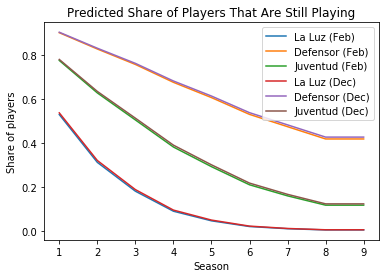

In [36]:
a=df_dummy[(df_dummy['teams_79']==1) & (df_dummy['mob_02']==1)].iloc[0,:].name
b=df_dummy[(df_dummy['teams_190']==1) & (df_dummy['mob_02']==1)].iloc[0,:].name
c=df_dummy[(df_dummy['teams_202']==1) & (df_dummy['mob_02']==1)].iloc[0,:].name
d=df_dummy[(df_dummy['teams_79']==1) & (df_dummy['mob_12']==1)].iloc[0,:].name
e=df_dummy[(df_dummy['teams_190']==1) & (df_dummy['mob_12']==1)].iloc[0,:].name
f=df_dummy[(df_dummy['teams_202']==1) & (df_dummy['mob_12']==1)].iloc[0,:].name

ni=['La Luz (Feb)','Defensor (Feb)','Juventud (Feb)','La Luz (Dec)','Defensor (Dec)','Juventud (Dec)']
sample=df_dummy.loc[[a,b,c,d,e,f]].iloc[:,2:]
sample.index=ni
cph.predict_survival_function(sample).plot()
plt.title('Predicted Share of Players That Are Still Playing')
plt.xlabel('Season')
plt.ylabel('Share of players')

From this comparison, we can see that most of the variation is given by the team instead of the month of birth. However, the two variables are not independent of each other. If Defensor selects players that are concentrated in the first months, while La Luz usually has a distribution closer to a uniform one, this mean that the La Luz effect could be related to the months (instead of being an effect of the team).
Actually, that is what it happens. La Luz (the team with the worst coefficient) recruits players with a distribution that where players in the first months of the year are not overrepresented. Juventud, a team in the second division but that has a coefficient closer to the teams in first division has more players born in the first months of the year. Defensor Sp., the best team in promoting younger players, recruits mostly players born in the first months of the year.

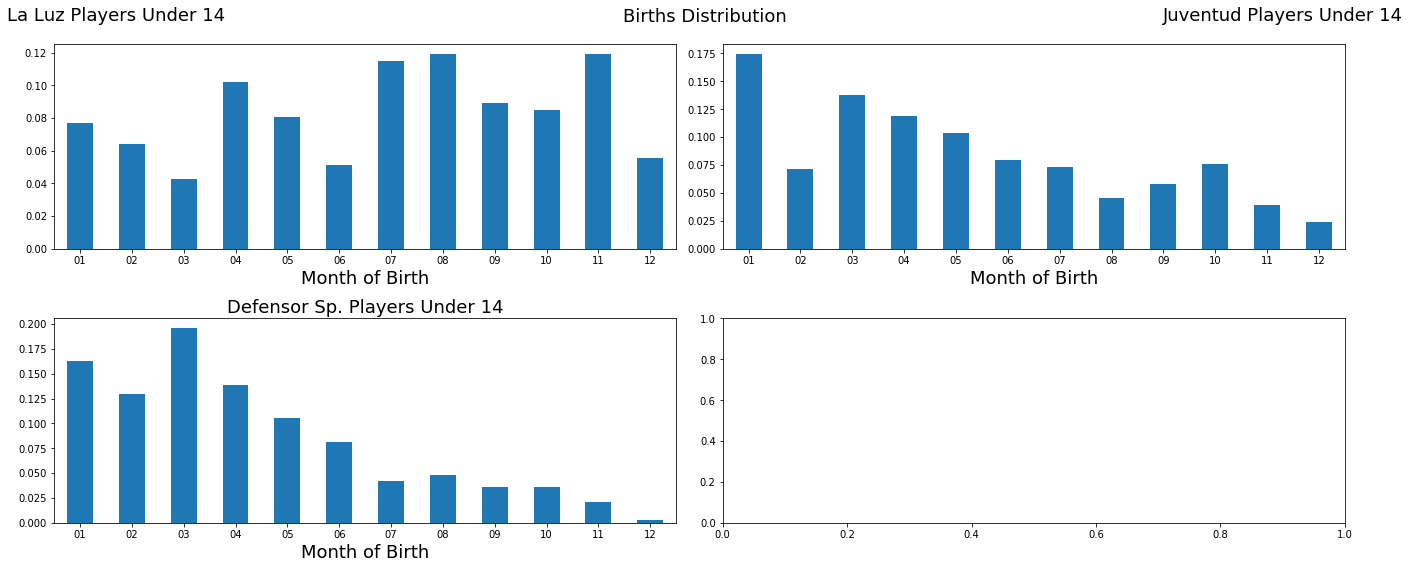

In [37]:
#Frequency of births for Males across months between the years 1999 and 2007.

series1=(df33[(df33['catord']==1) & (df33['teams']=='79')].groupby('mob').count()/len(df33[(df33['catord']==1) & (df33['teams']=='79')]))['index']
series2=(df33[(df33['catord']==1) & (df33['teams']=='202')].groupby('mob').count()/len(df33[(df33['catord']==1) & (df33['teams']=='202')]))['index']
series3=(df33[(df33['catord']==1) & (df33['teams']=='190')].groupby('mob').count()/len(df33[(df33['catord']==1) & (df33['teams']=='190')]))['index']
fig, axes = plt.subplots(2,2, figsize=(20,8))  # 1 row, 2 columns

axe=axes.ravel()

series1.plot.bar(rot=0,ax=axe[0])
series2.plot.bar(rot=0,ax=axe[1])
series3.plot.bar(rot=0,ax=axe[2])

fontsize = 18

fig.suptitle('Births Distribution', fontsize=fontsize) # or plt.suptitle('Main title')
axe[0].set_title('La Luz Players Under 14', fontsize=fontsize)
axe[1].set_title('Juventud Players Under 14', fontsize=fontsize)
axe[0].title.set_position([0.1,1.085])
axe[1].title.set_position([0.9,1.085])
axe[0].set_xlabel('Month of Birth', fontsize=fontsize)
axe[1].set_xlabel('Month of Birth', fontsize=fontsize)
axe[2].set_title('Defensor Sp. Players Under 14', fontsize=fontsize)
axe[2].set_xlabel('Month of Birth', fontsize=fontsize)




plt.tight_layout() 
#sexo==1: Male; sexo==2; Female




### Conclusions
* The relative age effect exists in Uruguay.
* Month of birth is somehow related to the future success of a young player. The best teams recruit players born in the year's first months. Once controlled for the team, the birth month does not seem to affect later survival. The effect corresponds to stages previous to recruitment.
* It is interesting how the birth month relates to future success and how this discrimination is almost inexistent in female leagues. 
* Could this discrimination be used as a proxy to evaluate how good the players are?